In [18]:
import pandas as pd

df = pd.read_csv('Cleaned/ML-Model-Data.csv')

# Filter out rows where 'YEAR_BUILT' and 'BIG_IMPROVEMENT_YEAR' are not in the range 1800-2024
df = df[(df['YEAR_BUILT'].between(1800, 2024)) & (df['BIG_IMPROVEMENT_YEAR'].between(1800, 2024))]

15557
15496


In [19]:
# Set a threshold for the land value and improvement value
land_value_threshold = 100000
improvement_value_threshold = 20000

# Columns related to land and improvement values
land_value_cols = [col for col in df.columns if 'CURRENT_LAND_VALUE' in col]
improvement_value_cols = [col for col in df.columns if 'CURRENT_IMPROVEMENT_VALUE' in col]

# Replace values below the threshold with 0
df[land_value_cols] = df[land_value_cols].applymap(lambda x: x if x >= land_value_threshold else 0)
df[improvement_value_cols] = df[improvement_value_cols].applymap(lambda x: x if x >= improvement_value_threshold else 0)

In [20]:
# Columns related to count per year
count_cols = [col for col in df.columns if 'Count_Per_Year' in col]

# Function to update counts with previous year's data if missing and resolve spikes
def update_counts(row):
    # Extract count values and sort them
    counts = row[count_cols].tolist()
    unique_counts = sorted(set(counts))
    
    # Check if there's more than two unique counts
    if len(unique_counts) > 2:
        # Use the two largest unique counts as the valid ones 
        hold = unique_counts[-2:]
        if ((hold[1] - hold[0]) > 4):
            unique_counts = hold
        else:
            unique_counts = unique_counts[-1:]
        
    # Update the row with the correct counts taking into account inflection points where new buildings were built
    for col in count_cols:
        if row[col] not in unique_counts:
            # Find the previous year column
            prev_col = count_cols[count_cols.index(col) - 1] if count_cols.index(col) > 0 else None
            # If there's a previous year, use that value, otherwise use the smallest of the unique counts
            row[col] = row[prev_col] if prev_col and pd.notnull(row[prev_col]) else unique_counts[0]
            
    
    return row

# Apply the function to each row
df = df.apply(update_counts, axis=1)


/tmp/ipykernel_13069/4170870.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  land_plot.set_xticklabels(land_plot.get_xticklabels(), rotation=90)
/tmp/ipykernel_13069/4170870.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  improvement_plot.set_xticklabels(improvement_plot.get_xticklabels(), rotation=90)


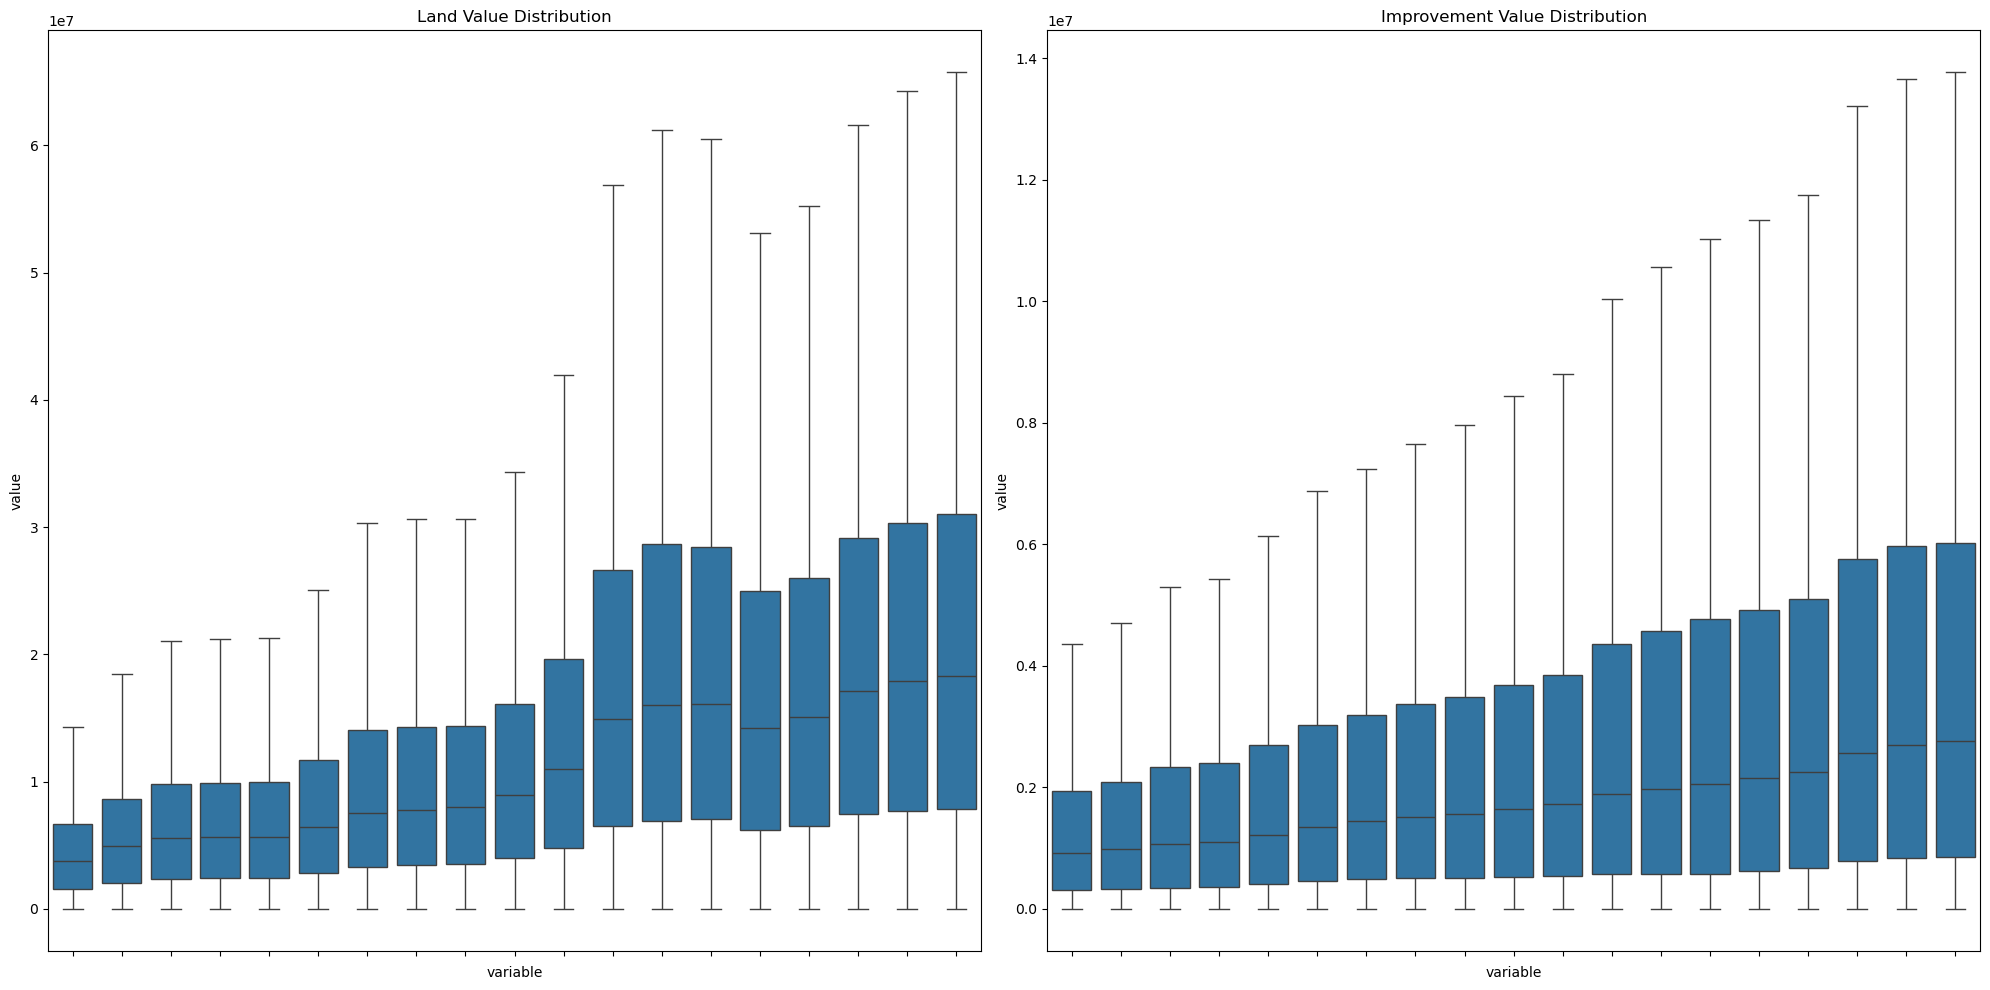

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

land_value_cols = [col for col in df.columns if 'CURRENT_LAND_VALUE' in col]
improvement_value_cols = [col for col in df.columns if 'CURRENT_IMPROVEMENT_VALUE' in col]

plt.figure(figsize=(20, 10))

# Plot the Land Value Distribution
plt.subplot(1, 2, 1)
land_data = pd.melt(df, value_vars=land_value_cols)
land_plot = sns.boxplot(data=land_data, x='variable', y='value', showfliers=False)
land_plot.set_title('Land Value Distribution')
land_plot.set_xticklabels(land_plot.get_xticklabels(), rotation=90)

# Plot the Improvement Value Distribution
plt.subplot(1, 2, 2)
improvement_data = pd.melt(df, value_vars=improvement_value_cols)
improvement_plot = sns.boxplot(data=improvement_data, x='variable', y='value', showfliers=False)
improvement_plot.set_title('Improvement Value Distribution')
improvement_plot.set_xticklabels(improvement_plot.get_xticklabels(), rotation=90)

plt.tight_layout()
plt.show()


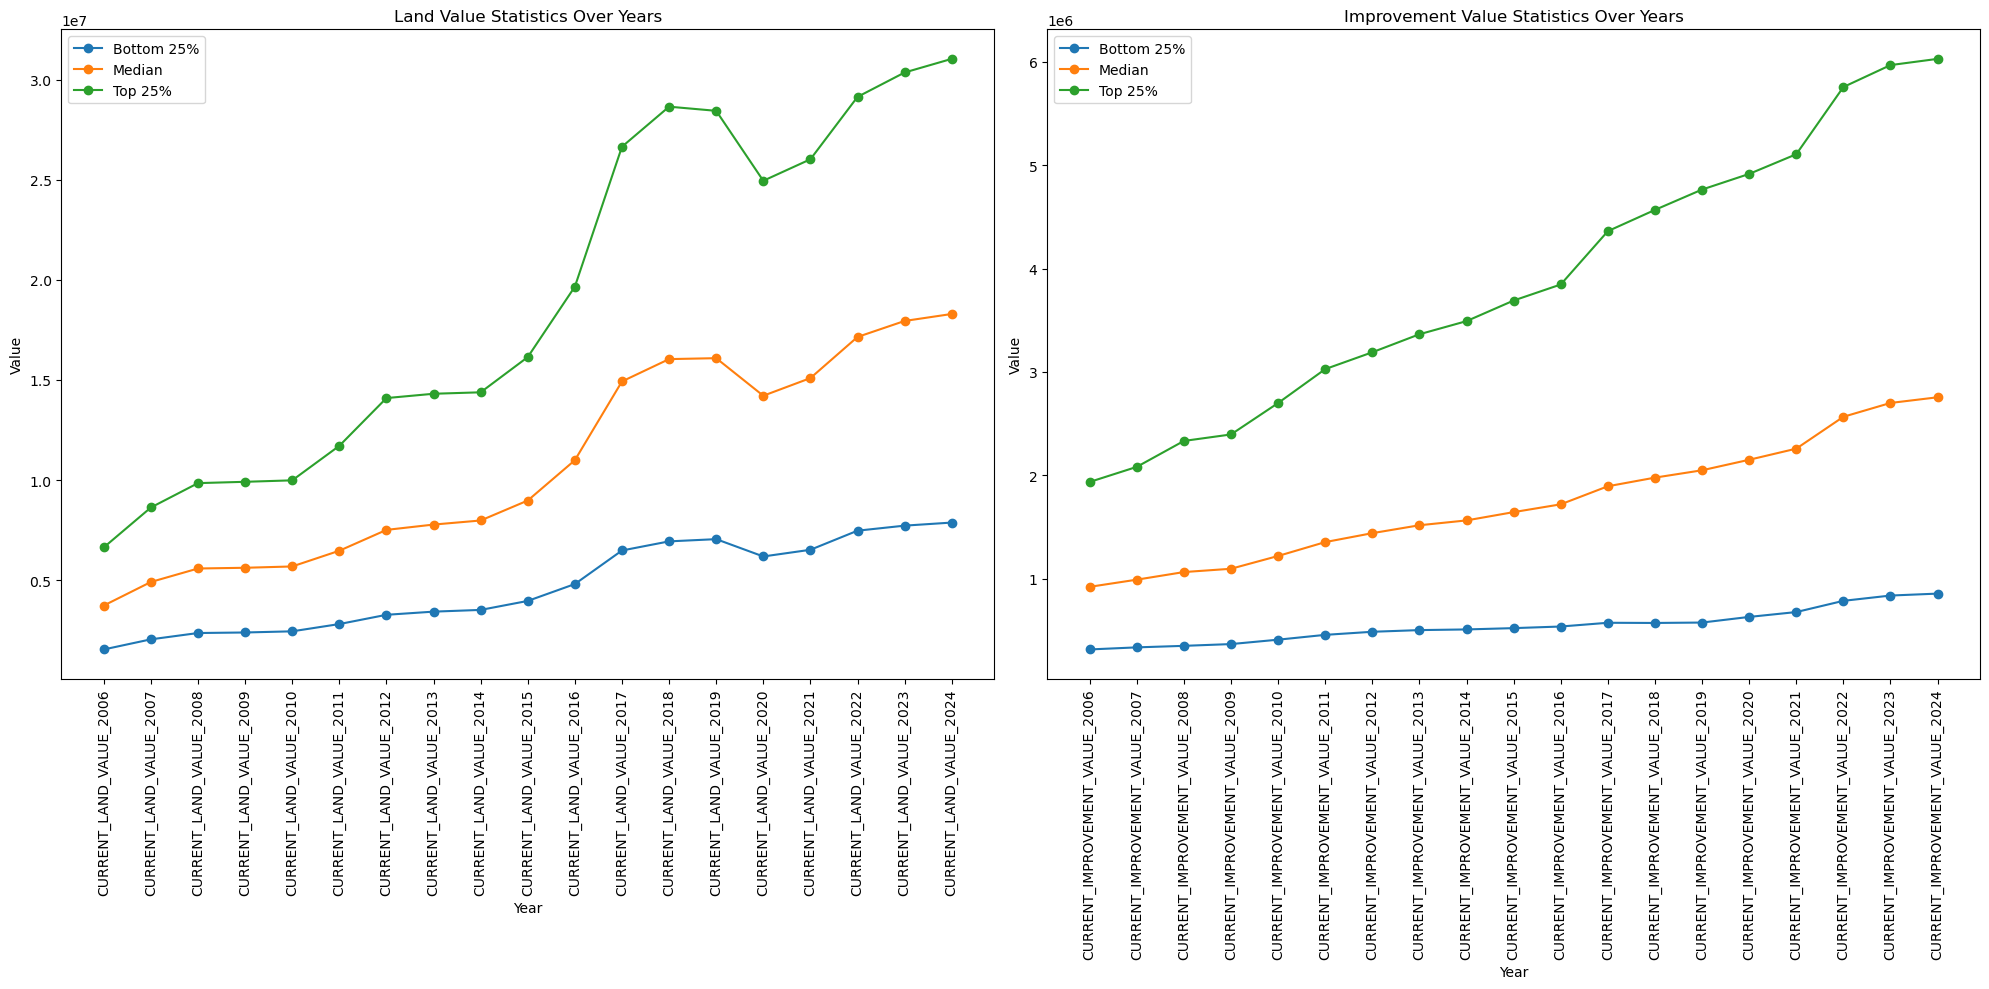

In [22]:
# Function to calculate the desired percentiles and median
def calculate_stats(data, columns):
    stats = pd.DataFrame(index=columns, columns=['25%', '50%', '75%'])
    for col in columns:
        stats.loc[col, '25%'] = data[col].dropna().quantile(0.25)
        stats.loc[col, '50%'] = data[col].dropna().median()
        stats.loc[col, '75%'] = data[col].dropna().quantile(0.75)
    return stats

# Calculate stats for land and improvement values
land_stats = calculate_stats(df, land_value_cols)
improvement_stats = calculate_stats(df, improvement_value_cols)

# Plotting the stats
plt.figure(figsize=(20, 10))

# Plot Land Value Stats
plt.subplot(1, 2, 1)
plt.plot(land_stats['25%'], label='Bottom 25%', marker='o')
plt.plot(land_stats['50%'], label='Median', marker='o')
plt.plot(land_stats['75%'], label='Top 25%', marker='o')
plt.title('Land Value Statistics Over Years')
plt.xlabel('Year')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.legend()

# Plot Improvement Value Stats
plt.subplot(1, 2, 2)
plt.plot(improvement_stats['25%'], label='Bottom 25%', marker='o')
plt.plot(improvement_stats['50%'], label='Median', marker='o')
plt.plot(improvement_stats['75%'], label='Top 25%', marker='o')
plt.title('Improvement Value Statistics Over Years')
plt.xlabel('Year')
plt.ylabel('Value')
plt.xticks(rotation=90)
plt.legend()

plt.tight_layout()
plt.show()


In [24]:
df.to_csv('Cleaned/ML-Model-Cleaned.csv', index=False)